In [1]:
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

In [2]:
def absolute_path_joiner(img_path: str):
    new_path = os.path.join(os.getcwd(), img_path)
    return new_path

In [19]:
SAMPLE_IMAGE_DIR = "../../../resources/need_annotating/OLOMBENDO/"
random.seed(42)
sample_images = random.choices(os.listdir(SAMPLE_IMAGE_DIR), k=10)
sample_image_paths = [
    os.path.join(SAMPLE_IMAGE_DIR, img) for img in sample_images
]
sample_image_paths = [absolute_path_joiner(img) for img in sample_image_paths]
flags = []
imgs = [
    cv.imread(img_path, cv.IMREAD_GRAYSCALE) for img_path in sample_image_paths
]
imgs_blurred = [cv.GaussianBlur(img, (5, 5), 0) for img in imgs]
imgs_binary = [
    cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    for idx, img in enumerate(imgs_blurred)
]

gray_cmap = plt.get_cmap("gray")

In [77]:
import cv2 as cv
import numpy as np
import math  # For checking non-finite numbers


def find_figure_contour(
    all_contours: list,
    img: np.ndarray,
    min_area_ratio: float = 0.01,  # Minimum contour area as a fraction of total image area
    edge_margin_ratio: float = 0.001,  # Margin (0.1%) from edge to detect artifacts
    area_drop_off_ratio: float = 1.75,  # Ratio threshold to detect significant area drop
) -> list:
    """
    Find the likely figure boundary contour from a list of all contours.

    1. Filters contours based on a minimum area threshold.
    2. Filters out contours too close to the image edges (artifacts).
    3. Identifies a group of primary contours by looking for a significant
       drop-off in area among the largest remaining contours.
    4. Selects the contour with the smallest area from this primary group
       as the likely figure boundary.

    Args:
        all_contours (list): List of all contours found in the image.
        img (numpy.ndarray): The image (used for dimensions).
        min_area_ratio (float): Minimum area threshold (fraction of total image area).
                                Defaults to 0.01 (1%).
        edge_margin_ratio (float): Border margin (fraction of width/height)
                                   to identify edge artifacts. Defaults to 0.001 (0.1%).
        area_drop_off_ratio (float): Area ratio between consecutive sorted contours
                                     that signifies a drop-off. Defaults to 1.75.

    Returns:
        list: A list containing only the identified figure contour,
              or an empty list if no suitable contour is found.
    """
    # 1. Get image dimensions and calculate minimum area threshold
    if len(img.shape) == 2:  # Grayscale
        h_img, w_img = img.shape
    else:  # Color
        h_img, w_img, _ = img.shape

    total_image_area = h_img * w_img
    min_area_threshold = total_image_area * min_area_ratio
    print(f"Image Dimensions (HxW): {h_img} x {w_img}")
    print(
        f"Minimum Area Threshold ({min_area_ratio*100:.2f}% of total): {min_area_threshold:.2f}"
    )

    # 2. Calculate edge thresholds
    x_thresh_min = edge_margin_ratio * w_img
    x_thresh_max = w_img - x_thresh_min
    y_thresh_min = edge_margin_ratio * h_img
    y_thresh_max = h_img - y_thresh_min
    print(
        f"Edge Thresholds: x=[{x_thresh_min:.2f}, {x_thresh_max:.2f}], y=[{y_thresh_min:.2f}, {y_thresh_max:.2f}]"
    )

    # 3. Initial filtering (Area and Edge Artifacts)
    valid_contours_data = []
    print(f"Received {len(all_contours)} initial contours.")
    for contour in all_contours:
        area = cv.contourArea(contour)

        # Check minimum area
        if area < min_area_threshold:
            continue  # Skip small contours

        # Get bounding box and check edge proximity
        x, y, w, h = cv.boundingRect(contour)
        x_max = x + w
        y_max = y + h

        is_edge_artifact = (
            x < x_thresh_min
            or y < y_thresh_min
            or x_max > x_thresh_max
            or y_max > y_thresh_max
        )

        if is_edge_artifact:
            # print(f"  - Discarding contour near edge: area={area:.2f}, bbox=[{x},{y},{w},{h}]")
            continue  # Skip edge artifacts

        # If contour is valid, store it with its area
        valid_contours_data.append({"contour": contour, "area": area})

    print(
        f"Found {len(valid_contours_data)} contours after area and edge filtering."
    )

    # Check if any contours remain
    if not valid_contours_data:
        print("Warning: No valid contours remaining after initial filtering.")
        return []

    # 4. Sort remaining contours by area (descending)
    valid_contours_data.sort(key=lambda item: item["area"], reverse=True)

    # 5. Find significant area drop-off
    primary_candidates = []
    if len(valid_contours_data) == 1:
        # If only one contour remains, it's our only candidate
        primary_candidates = valid_contours_data
        print(
            "Only one valid contour remains. Considering it the primary candidate."
        )
    else:
        # Add the largest contour unconditionally
        primary_candidates.append(valid_contours_data[0])
        print(f"Largest contour area: {valid_contours_data[0]['area']:.2f}")

        # Iterate through sorted contours to find the drop-off point
        for i in range(len(valid_contours_data) - 1):
            current_area = valid_contours_data[i]["area"]
            next_area = valid_contours_data[i + 1]["area"]

            # Avoid division by zero or near-zero
            if next_area <= 1e-6:  # Use a small epsilon
                print(
                    f"  - Next contour area is near zero ({next_area:.2f}), stopping drop-off check."
                )
                break

            ratio = current_area / next_area
            print(
                f"  - Comparing contour {i} (Area: {current_area:.2f}) to {i+1} (Area: {next_area:.2f}). Ratio: {ratio:.2f}"
            )

            # Check for non-finite ratio (can happen if next_area is 0)
            if not math.isfinite(ratio):
                print(f"  - Ratio is non-finite, stopping drop-off check.")
                break

            if ratio >= area_drop_off_ratio:
                # Significant drop found, stop including contours
                print(
                    f"  - Significant area drop-off detected (Ratio {ratio:.2f} >= {area_drop_off_ratio}). Stopping."
                )
                break
            else:
                # No significant drop yet, include the next contour
                primary_candidates.append(valid_contours_data[i + 1])

    print(
        f"Identified {len(primary_candidates)} primary candidates before area drop-off."
    )

    # 6. Select the smallest area contour from the primary candidates
    if not primary_candidates:
        print(
            "Warning: No primary candidates identified (this shouldn't happen if valid_contours_data was not empty)."
        )
        return []

    # Sort the candidates by area ascending to find the smallest
    primary_candidates.sort(key=lambda item: item["area"])
    figure_contour_data = primary_candidates[0]

    print(
        f"Selected figure contour with area: {figure_contour_data['area']:.2f}"
    )

    # 7. Return the identified figure contour
    return [figure_contour_data["contour"]]

Image Dimensions (HxW): 3392 x 4768
Minimum Area Threshold (1.00% of total): 161730.56
Edge Thresholds: x=[4.77, 4763.23], y=[3.39, 3388.61]
Received 7202 initial contours.
Found 11 contours after area and edge filtering.
Largest contour area: 14744512.00
  - Comparing contour 0 (Area: 14744512.00) to 1 (Area: 11931189.50). Ratio: 1.24
  - Comparing contour 1 (Area: 11931189.50) to 2 (Area: 1703825.50). Ratio: 7.00
  - Significant area drop-off detected (Ratio 7.00 >= 1.75). Stopping.
Identified 2 primary candidates before area drop-off.
Selected figure contour with area: 11931189.50

Final Result: Figure contour identified. Number of points: 1488


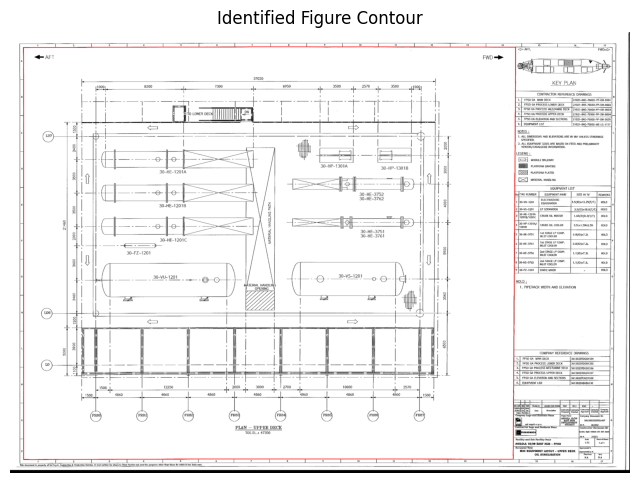

In [93]:
img_no = 9
img = imgs[img_no]
display_scale = 0.5

ret, thresh = cv.threshold(img, 127, 255, 0)
all_contours, hierarchy = cv.findContours(
    thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE
)

# Use the function
figure_contour_list = find_figure_contour(
    all_contours,
    img,
    min_area_ratio=0.01,      # 1% min area
    edge_margin_ratio=0.001,  # 0.1% edge margin
    area_drop_off_ratio=1.75  # Drop-off if area ratio > 1.75
)

# Process the result
if figure_contour_list:
    print(f"\nFinal Result: Figure contour identified. Number of points: {len(figure_contour_list[0])}")
    # Draw the result (optional)
    img_to_draw_on = cv.cvtColor(img, cv.COLOR_GRAY2BGR) if len(img.shape)==2 else img.copy()
    cv.drawContours(img_to_draw_on, figure_contour_list, -1, (0, 0, 255), 3) # Draw in red
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,8))
    plt.imshow(cv.cvtColor(img_to_draw_on, cv.COLOR_BGR2RGB))
    plt.title("Identified Figure Contour")
    plt.axis('off')
    plt.show()
else:
    print("\nFinal Result: Could not identify the figure contour based on the criteria.")